# Diffusion-TS : Interpretable Diffusion for General Time Series Generation



The notebook is a re-implementation of the paper 'Diffusion-TS: interpretable diffusion for general time series generation'.

### Objective of the paper
The objective of the chosen paper is to introduce Diffusion-TS, a novel time series generation model that leverages denoising diffusion probabilistic models (DDPMs) integrated with interpretable seasonal-trend decomposition.

### Methodology
1. <b>Model Structure</b>: The model uses a Transformer-inspired architecture for encoding and decoding time series data.
2. <b>Decomposition</b>: The time series is decomposed into trend, seasonal, and residual components to ensure interpretability.
3. <b>Training</b>: The model is trained using a combination of reconstruction-based guidance and traditional noise prediction parameterization.
4. <b>Dataset</b>: The model’s performance is evaluated on various real-world and synthetic datasets.


### Model
The Diffusion-TS model is a Transformer model, coded in the $\texttt{transformer\textunderscore model.py} $ script, that consists of two main components:
1. <b>Sequence Encoder</b> - $ \texttt{encoder.py} $
2. <b>Interpretable Decoder </b> $ \texttt{- decoder.py} $

#### Encoder
The encoder is characterized by a <u>Full Attention</u> mechanism, which allows the model to focus on relevant parts of the input sequence, and a <u>Feed Forward</u> network that helps in transforming the input data into a suitable representation for further processing.

#### Decoder
The decoder is composed of several layers in which each decoder block contains a <u>Transformer block</u>, a <u>Feed Forward</u> network block and <u>Interpretable Layers</u>.
The Interpretable Layers comprise Trend Layer and Fourier Layer for the representation of trend and seasonality&error respectively.


### Diffusion Framework - DDPM
The diffusion model tipically is subdivided in two processes, forward and reverse. The forward process consists in noise a sample $ x_0 \sim q(x) $ from the data distribution, into a Gussian noise $ x_T \sim \mathcal{N}(0, \mathbf{I}) $. The reverse step instead is learned by a neural network, consisting in gradually denoising the sample via reversed transition. This process can be reduced to learning to build a surrogate approximator to parameterize $ \mu_\theta(x_t, t) $. This objective can be justified as optimizing a weighted variational lower bound on the data log likelihood.


To ensure that the model can unsupervisedly uncover the time-series components, the neural network is trained to predict an estimate of $ \hat{x}_0(x_t, t, \theta) $. The reverse process can then be approximated by the equation:
$$ x_{t-1} = \frac{\sqrt{\bar{\alpha}_t - 1} \beta_t}{1 - \bar{\alpha}_t} \hat{x}_0(x_t, t, \theta) + \frac{\sqrt{\alpha_t(1 - \bar{\alpha}_{t-1})}}{1 - \bar{\alpha}_t} x_t + \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_t z_t $$
where $ z_t \sim \mathcal{N}(0, \mathbf{I}) $, $ \alpha_t = 1 - \beta_t $ and $ \bar{\alpha}_t = \prod^t_{s=1}\alpha_s $.

To enhance interpretable diffusion training, it's applied to the frequency domain using the Fourier transform, a mathematical operation that converts a finite-length time-domain signal into its frequency domain representation. The Fourier-based loss term is beneficial for the accurate reconstruction of the time series signals.

$$ \mathcal{L}_\theta = \mathbb{E}_{t, x_0} \left[ w_t \left[ \lambda_1 \| x_0 - \hat{x}_0(x_t, t, \theta) \|^2 + \lambda_2 \| FFT(x_0) - FFT(\hat{x}_0(x_t, t, \theta)) \|^2 \right] \right] $$

$ \lambda_1 $ and $ \lambda_2 $ are weights to balance the loss.

### Disentangled Representation
The disentanglement is achieved by the different <u>Interpretable Layers</u> present in the decoder structure.



#### Trend
Designed to capture the underlying smooth trend in the time series data. The trend represents the general direction or pattern that the data follows over time.
It is modeled using a polynomial regressor that helps fitting a polynomial curve that best represents the behavior of the data.
The trend syntesis is performed by the class TrendLayer in model_classes.py.
The trend component is calculated as:

$$ V_{\text{tr}}^t = \sum_{i=1}^D \left( C \cdot \text{Linear}(w_{\text{tr}}^{i,t}) + X_{\text{tr}}^{i,t} \right) $$


#### Seasonality & Error
Recover automatically the seasonal patterns and distinguish them from the noisy input is the main challenge.
The seasonal component of the time series is captured using Fourier bases, through different steps:
1. Computation of the Fourier transform of the intermadiate activations $ w_{\text{seas}}^{i,t} $ and computation of the amplitude and the phase of the k-th frequency:
$$ A_{i,t}^{(k)} = \left| \mathcal{F}(w_{\text{seas}}^{i,t})_k \right|, \quad \Phi_{i,t}^{(k)} = \phi \left( \mathcal{F}(w_{\text{seas}}^{i,t})_k \right) $$

2. Select the top K amplitudes:
$$ \kappa_{i,t}^{(1)}, \ldots, \kappa_{i,t}^{(K)} = \text{arg TopK}_{k \in \{1, \ldots, \lfloor \tau / 2 \rfloor + 1\}} \left\{ A_{i,t}^{(k)} \right\} $$

3. Reconstruct the seasonal component using the selected frequencies:
$$ S_{i,t} = \sum_{k=1}^K A_{\kappa_{i,t}^{(k)},i,t} \left[ \cos \left( 2\pi f_{\kappa_{i,t}^{(k)}} \tau c + \Phi_{\kappa_{i,t}^{(k)},i,t} \right) + \cos \left( 2\pi \bar{f}_{\kappa_{i,t}^{(k)}} \tau c + \bar{\Phi}_{\kappa_{i,t}^{(k)},i,t} \right) \right] $$

The Fourier synthetic layer selects bases with the most significant amplitudes in the frequency domain, and then returns to the time domain through an inverse transform to model the seasonality.

## Synthetic data generation - experiment 2

The second experiment is used to demonstrate the performance of time series synthesis, by training the network on a high-dimensional dataset like the energy dataset, and afterwards performing long-term time series generation. The efficiently new generated data implies the efficacy of interpretable decomposition for long-term time-series modeling.

Dataset used: energy_data.csv
The Energy dataset is a UCI appliance energy prediction dataset, an experimental data used to create regression models of appliances energy use in a low energy building.

The performance of time series synthesis is visualized in two methods: the projection of the original and synthetic data in a 2-dimensional space using t-SNE, and the draw of the data distributions using kernel density estimation.

### Imports 
First of all is crucial to import the necessary library and functions from the Scripts folder:
- the trainer script for the training of the model
- the data loader to load the dataset located in the Data folder
- some utility functions

In [1]:
import os
import torch
import numpy as np

import warnings
warnings.filterwarnings('ignore', module='tqdm')

from Scripts.trainer import Trainer
from Scripts.get_dataLoader import get_dataloader
from Scripts.utility_func import load_yaml, create_instance_from_config, unnormalize_to_zero_to_one
from Scripts.display import visualization

### Set up

Initialization of:
- the path to the configuration file where a set of configurations is specified
- the output folder
- the data loader for the dataset
- the trainer object with several parameters
- the model based on the configurations specified in the .yaml file

In [2]:
config_path = './Config/energy.yaml'
save_dir = './output/energy/'
gpu = 0
os.makedirs(save_dir, exist_ok=True)

configs = load_yaml(config_path)
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

dl_info = get_dataloader(configs, save_dir)
model = create_instance_from_config(configs['model']).to(device)
trainer = Trainer(model=model, dataloader=dl_info, device=device, \
                  train_num_steps=configs['solver']['max_epochs'], \
                  gradient_accumulate_every=configs['solver']['gradient_accumulate_every'], \
                  save_cycle=configs['solver']['save_cycle'], \
                  results_folder=configs['solver']['results_folder'], \
                  start_lr=configs['solver'].get('base_lr', 1.0e-4), \
                  ema_decay=configs['solver']['ema']['decay'], \
                  ema_update_every=configs['solver']['ema']['update_interval'], \
                  sc_cfg=configs['solver']['scheduler'])

### Training
Call of the train loop. 
The training code, contained in the script $ \texttt{trainer.py} $, trains the model by repeatedly feeding batches of data into the model, computing the loss, backpropagating the gradients, and updating the model parameters. 

In the loop is also applied a gradient clipping to prevent exploding gradients.

The script also save check points of the training after a fixed number of epochs. #TODO see if can be riemoved and just save the whole train at the end

In [3]:
trainer.train(seed=123)

Global seed set to 123


  0%|          | 0/25000 [00:00<?, ?it/s]

loss: 9.371810:   0%|          | 8/25000 [00:03<3:08:26,  2.21it/s]


KeyboardInterrupt: 

### Inference

#### Sampling
Generation of the synthetic data by means of the sample function. The dataset is retrieved, if the <i>fake</i> data is not already present in the output folder, meaning thet the data generation has been already performed, the <i>sample</i> function is called and uses the trained model to generate data that is similar to to the original data.

In [3]:
dataset = dl_info['dataset']
seq_length, feature_dim = dataset.window, dataset.var_num
ori_data = np.load(os.path.join(dataset.dir, f"energy_norm_truth_{seq_length}_train.npy"))
print('Original data loaded')
#try catch for case of existing fake data
try:
    fake_data = np.load(os.path.join(save_dir, f'ddpm_fake_energy.npy'))
    print('Fake data loaded')
except:
    fake_data = trainer.sample(num=len(dataset), size_every=2001, shape=[seq_length, feature_dim])
    if dataset.auto_norm:
        fake_data = unnormalize_to_zero_to_one(fake_data)
        np.save(os.path.join(save_dir, f'ddpm_fake_energy.npy'), fake_data)

Original data loaded
Fake data loaded


### Visualization
The results of the inference can be visualized using the two prevously mentioned methods, t-SNE and kernel density estimation-
In the plots both original and synthetic data are displayed.

#TODO add comments to the plots

In [ ]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', save_path=save_dir, compare=ori_data.shape[0])

/Users/vale/Desktop/Sapienza/Neural Networks/NN_proj/Scripts/display.py:79: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prep_data, hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
/Users/vale/Desktop/Sapienza/Neural Networks/NN_proj/Scripts/display.py:80: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/m

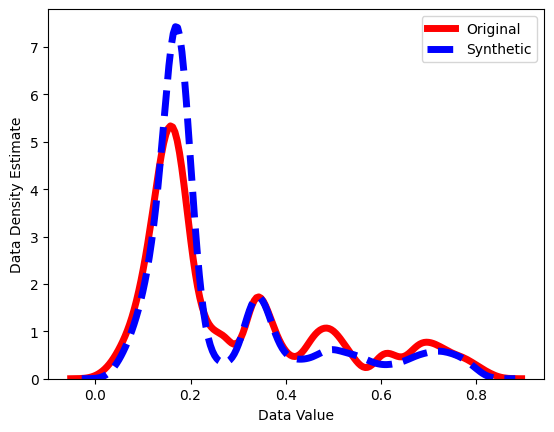

In [4]:
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', save_path=save_dir, compare=ori_data.shape[0])

## Trend and Seasonality learning - experiment 1

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from Scripts.trainer import Trainer
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from Scripts.get_dataLoader import get_dataloader
from Scripts.utility_func import load_yaml, create_instance_from_config, normalize_to_neg_one_to_one, data_generation

In [2]:
class CreateDataset(Dataset):
    def __init__(self, data1, data2, period='train'):
        super(CreateDataset, self).__init__()
        self.season = data1
        self.trend = data2
        self.samples = data1 + data2
        self.period = period

    def __getitem__(self, ind):
        x = self.samples[ind, :, :]
        if self.period == 'train':
            return torch.from_numpy(x).float()
        
        t = self.trend[ind, :, :]
        s = self.season[ind, :, :]
        return torch.from_numpy(x).float(), torch.from_numpy(t).float(),\
               torch.from_numpy(s).float()

    def __len__(self):
        return self.samples.shape[0]

In [3]:
data1, data2 = data_generation(1000, seq_len=160, dim=5)

Global seed set to 1234


Generating data:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating data: 100%|██████████| 1000/1000 [00:00<00:00, 1578.81it/s]


In [4]:
scaler = MinMaxScaler()
scaler.fit((data1 + data2).reshape(-1, 5))
season = normalize_to_neg_one_to_one(scaler.transform(data1.reshape(-1, 5)).reshape(data1.shape))
trend = normalize_to_neg_one_to_one(scaler.transform(data2.reshape(-1, 5)).reshape(data2.shape))

train_dataset = CreateDataset(season, trend, period='train')
test_dataset = CreateDataset(season, trend, period='test')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True, sampler=None)


In [5]:
config_path = './Config/config.yaml'
save_dir = './interpretability/sines/'
gpu = 0
os.makedirs(save_dir, exist_ok=True)

configs = load_yaml(config_path)
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

model = create_instance_from_config(configs['model']).to(device)
trainer = Trainer(model=model, dataloader={'dataloader':dataloader}, device=device, \
                  train_num_steps=configs['solver']['max_epochs'], \
                  gradient_accumulate_every=configs['solver']['gradient_accumulate_every'], \
                  save_cycle=configs['solver']['save_cycle'], \
                  results_folder=configs['solver']['results_folder'], \
                  start_lr=configs['solver'].get('base_lr', 1.0e-4), \
                  ema_decay=configs['solver']['ema']['decay'], \
                  ema_update_every=configs['solver']['ema']['update_interval'], \
                  sc_cfg=configs['solver']['scheduler'])

In [6]:
#remember to modify the seed injection in the training and the sampling
trainer.train(seed=1234)

Global seed set to 123


loss: 0.049534: 100%|██████████| 1000/1000 [56:23<00:00,  3.38s/it]

training complete


In [7]:
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True, sampler=None)
data, trend_r, season_r = next(iter(dataloader))
data, trend_r, season_r = data.to(device), trend_r.to(device), season_r.to(device)

interpretable_model = trainer.model.to(device)
interpretable_model.eval()

t = int(interpretable_model.num_timesteps // 2)  # noisy degree
trend, season, r, x = interpretable_model.return_components(data, t)

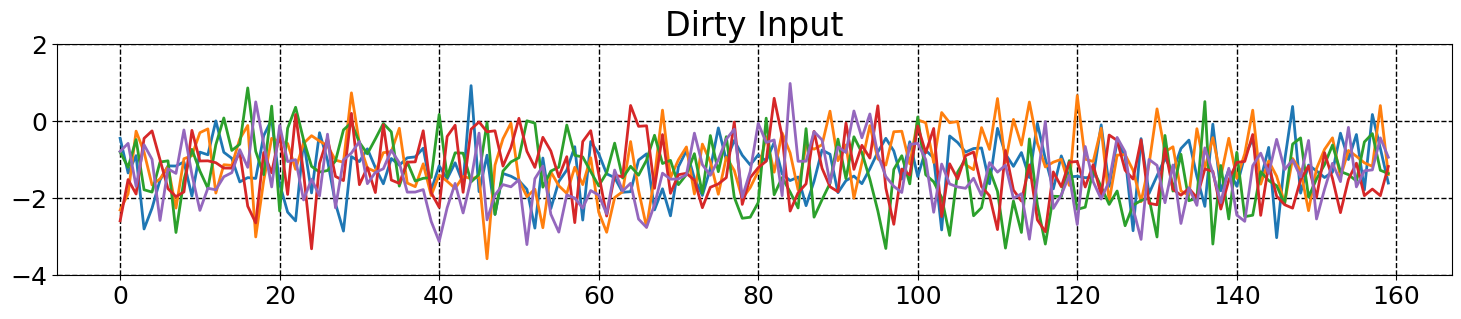

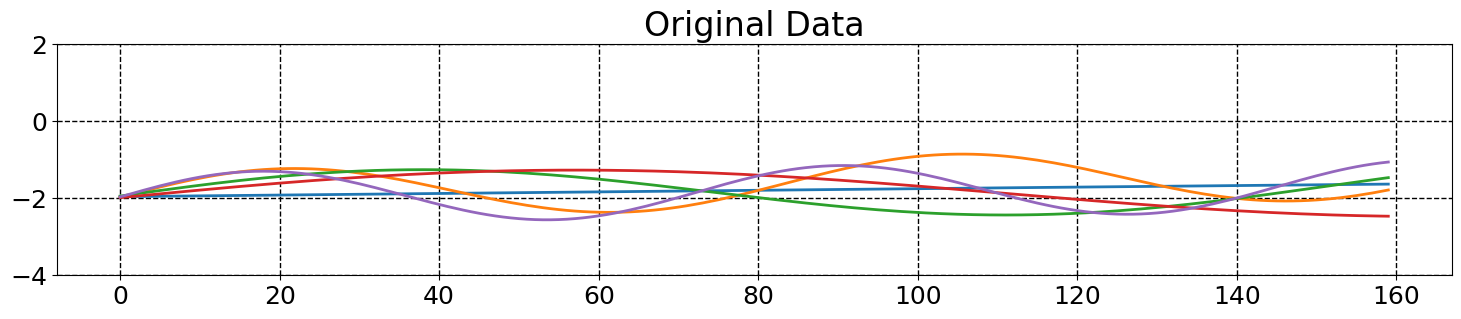

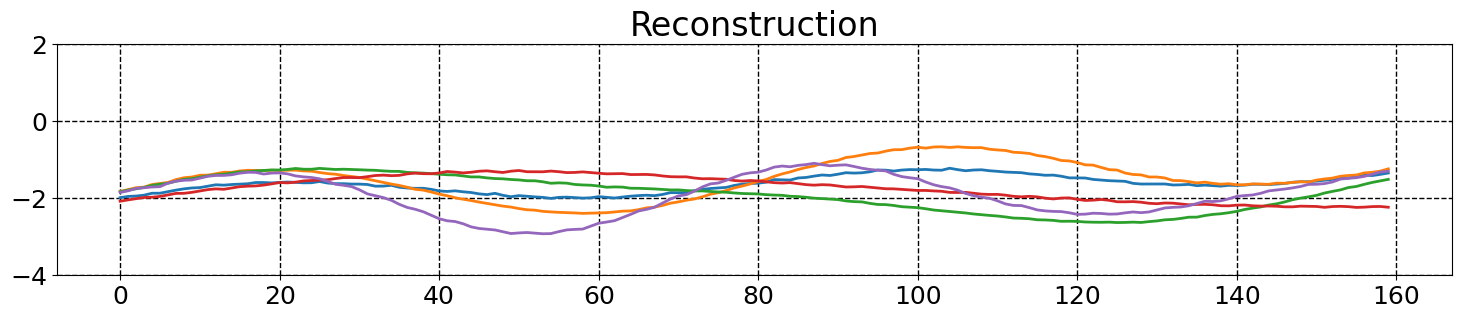

In [20]:
idx, size = 0, 5
dir = f'./OUTPUT/figures/fig_{t}'
os.makedirs(dir, exist_ok=True)

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(x[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Dirty Input', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-4, 2))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(data[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Original Data', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-4, 2))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot((trend + season + r)[idx, :, -i].cpu().detach().numpy().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Reconstruction', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-4, 2))
plt.show()

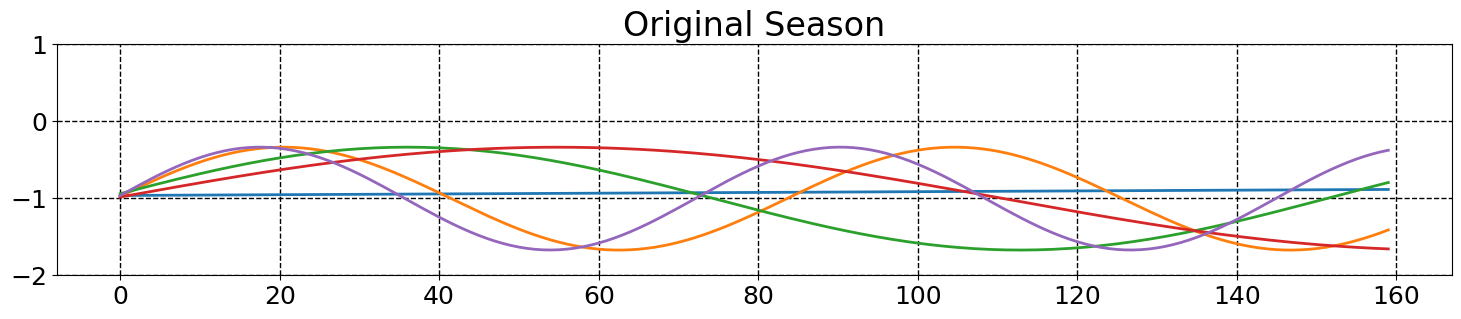

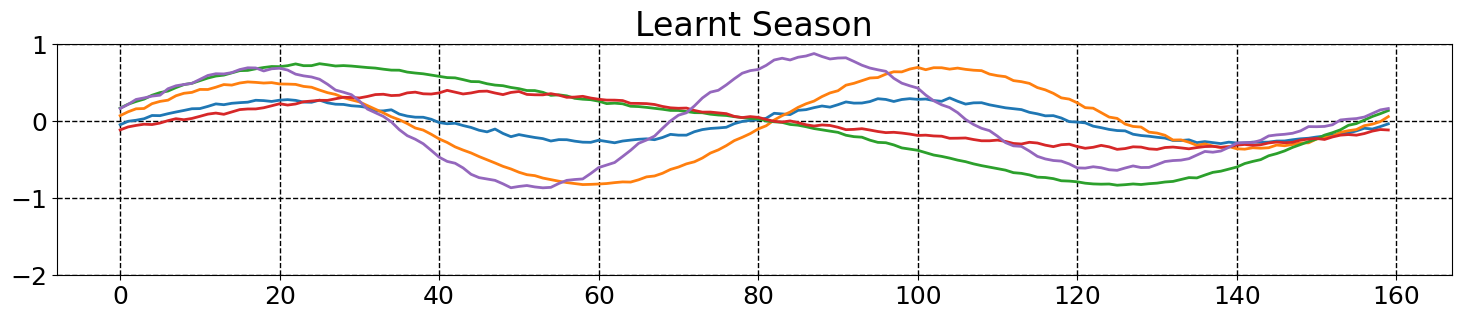

In [16]:
plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(season_r[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Original Season', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-2, 1))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(season[idx, :, -i].cpu().detach().numpy().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Learnt Season', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-2, 1))
plt.show()

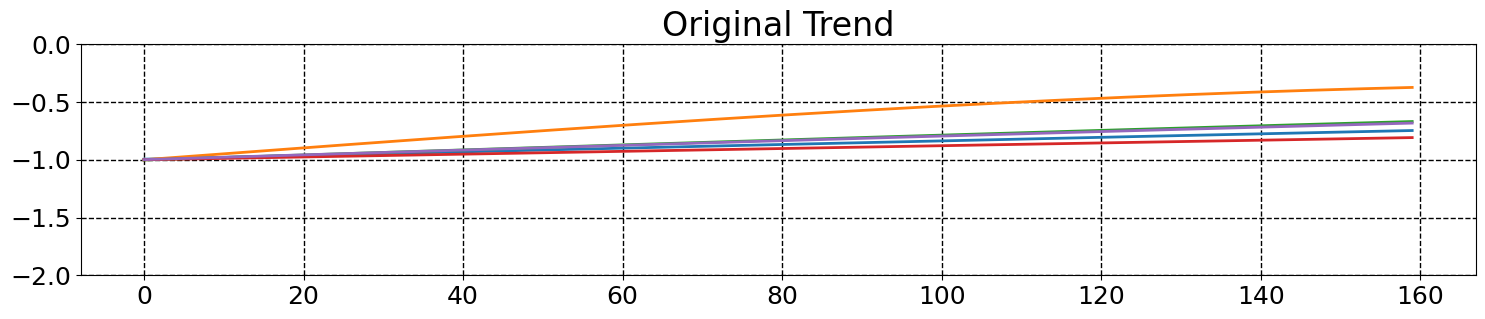

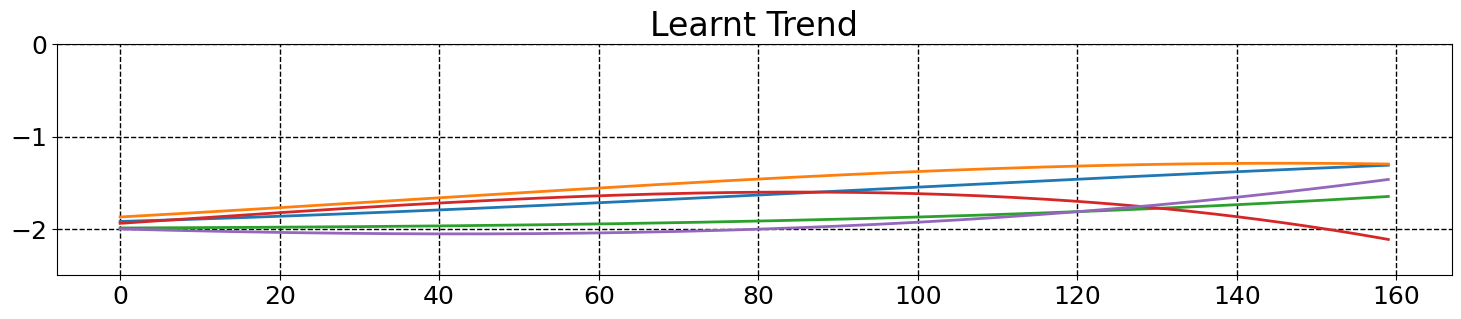

In [19]:
plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(trend_r[idx, :, -i].cpu().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Original Trend', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-2, 0))
plt.show()

plt.figure(figsize=(18, 3))
for i in range(size):
    plt.plot(trend[idx, :, -i].cpu().detach().numpy().flatten(), lw=2)
plt.grid(color='k', ls ='--', lw=1)
plt.title('Learnt Trend', fontsize=24)
plt.tick_params('both', labelsize=18)
plt.ylim((-2.5, 0))
plt.show()